## Intro

Groups New York City neighborhoods (PUMAs) together based on characteristics measuring access and livability.

Input Variables:
    
    * Park access: park_access["park_perc"]
    * Job access: job_access["job_perc"]
    * Affordable housing: <30% of HH income: 100-housing["GRPI30_19P"],
                          <50% of HH income: 100-housing["GRPI50_19P"]
    * Home ownership: housing["OOcc1_19P"]
    * Broadband access: housing["Comp_19P"]
    * Computer access: housing["BbInt_19P"]
    * Employment rate: hh_econ["CvEm1_19E"]/hh_econ["LF_19E"]
    * Bachelor's degree or higher: hh_econ["Bchpl_19P"]

TO ADD:
    
    * Access to transit
    * HS graduation rate
    * Self-reported health

Variables for post-clustering inspection:
    
    * Distribution of household income groups (hh_econ["ELI_19P"], hh_econ["VLI_19P"], hh_econ["LI_19P"], 
    hh_econ["MI_19P"], hh_econ["MIDI_19P"], hh_econ["HI_19P"])
    
    * Distribution of race/ethnicity groups (race_dec["Hsp20P"], race_dec["WNH20P"], race_dec["BNH20P"],
    race_dec["ANH20P"], race_dec["OTwoNH20P"])

## Libraries

In [1]:
import pandas as pd
import numpy as np
import os
import datetime as dt
import geopandas as gpd
from functools import reduce
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [2]:
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN
from scipy.spatial.distance import cdist, pdist
import scipy.cluster.hierarchy as shc

## Load Data Sets
Downloaded from Equitable Development Data Explorer GitHub repository: https://github.com/NYCPlanning/db-equitable-development-tool/tree/main/resources

In [3]:
path = '../data/'
job_access_path = 'access_to_jobs.csv'
housing_path = 'EDDT_ACS2015-2019.xlsx'
race_dec_path = 'EDDT_Census00-10-20_MUTU.xlsx'
demog_19_path = 'EDDT_Dem_ACS2015-2019.xlsx'
hh_econ_path = 'EDDT_HHEconSec_ACS2015-2019.xlsx'
units_aff_path = 'EDDT_UnitsAffordablebyAMI_2015-2019.xlsx'
dri_path = 'Equitable.Development.Data.Tool.-.Displacement.Risk.Index.2-8-2022.1.xlsx'
park_access_path = 'Park_Access.xlsx'

In [4]:
boro_names = ['NYC','Bronx','Brooklyn','Manhattan','Queens','Staten Island']

In [5]:
park_access = pd.read_excel(f'{path}{park_access_path}')
park_access = park_access.loc[~park_access['PUMA'].isin(boro_names)]
park_access.rename(columns={'Perc':'park_perc','PUMA':'PUMA_short'},inplace=True)
park_access['PUMA'] = '360'+park_access['PUMA_short'].astype(str)
park_access.head()

,PUMA_short,Pop_Served,Total_Pop20,park_perc,PUMA
0,3701,104085,113700,91.543536,3603701
1,3702,94287,148709,63.403694,3603702
2,3703,61828,123837,49.926920,3603703
3,3704,110207,130351,84.546340,3603704
4,3705,176653,178035,99.223748,3603705


In [6]:
hh_econ = pd.read_excel(f'{path}{hh_econ_path}')
hh_econ = hh_econ.loc[~hh_econ['Geog'].isin(boro_names)]
hh_econ['PUMA'] = '360'+hh_econ['Geog'].astype(str)
hh_econ.head()

,Geog,P25p_19E,P25p_19M,P25p_19C,P25p_19P,P25p_19Z,LtHS_19E,LtHS_19M,LtHS_19C,LtHS_19P,...,MWoth_A19M,MWoth_A19C,MWoth_A19P,MWoth_A19Z,MWpbadm_A19E,MWpbadm_A19M,MWpbadm_A19C,MWpbadm_A19P,MWpbadm_A19Z,PUMA
6,3701,77539,1586,1.2,100,NaN,14093,1163,5.0,18.2,...,NaN,NaN,NaN,NaN,139284.0,162682.0,71.0,NaN,NaN,3603701
7,3702,101302,1996,1.2,100,NaN,19953,1337,4.1,19.7,...,NaN,NaN,NaN,NaN,13735.0,37476.0,165.9,NaN,NaN,3603702
8,3703,87544,2326,1.6,100,NaN,14779,1623,6.7,16.9,...,120584.0,473.0,NaN,NaN,22498.0,19396.0,52.4,NaN,NaN,3603703
9,3704,88338,1839,1.3,100,NaN,19059,1212,3.9,21.6,...,5042.0,19.7,NaN,NaN,80657.0,29300.0,22.1,NaN,NaN,3603704
10,3705,101379,2083,1.2,100,NaN,34831,1725,3.0,34.4,...,34808.0,111.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3603705


In [7]:
job_access = pd.read_csv(f'{path}{job_access_path}')
job_access['PUMA'] = job_access['PUMA'].astype(str)
job_access = job_access.loc[~job_access['PUMA'].isin(boro_names)]
job_access = pd.merge(job_access,hh_econ[['PUMA','LF_19E']],how='left',on='PUMA')
job_access['job_perc'] = (job_access[
    'Weighted Average Number of Jobs Accessible within 30 mins from Tract Centroid by Transit']*100)/job_access['LF_19E']
job_access.head()

,PUMA,Weighted Average Number of Jobs Accessible within 30 mins from Tract Centroid by Transit,LF_19E,job_perc
0,3603701,45439,50545,89.898111
1,3603702,33763,72051,46.859863
2,3603703,20265,55725,36.366083
3,3603704,53255,60205,88.456108
4,3603705,81569,70950,114.966878


In [8]:
job_access['job_perc_norm'] = (job_access['job_perc']-job_access['job_perc'].min())*100/(job_access['job_perc'].max()-job_access['job_perc'].min())
job_access.job_perc_norm.describe()

count     55.000000
mean      14.914076
std       23.019639
min        0.000000
25%        3.276029
50%        6.759761
75%       11.301514
max      100.000000
Name: job_perc_norm, dtype: float64

In [9]:
housing = pd.read_excel(f'{path}{housing_path}')
housing = housing.loc[~housing['Geog'].isin(boro_names)]
housing['PUMA'] = '360'+housing['Geog'].astype(str)
housing.head()

,Geog,OcHU1_19E,OcHU1_19M,OcHU1_19C,OcHU1_19P,OcHU1_19Z,OOcc1_19E,OOcc1_19M,OOcc1_19C,OOcc1_19P,...,Comp_A19M,Comp_A19C,Comp_A19P,Comp_A19Z,BbInt_A19E,BbInt_A19M,BbInt_A19C,BbInt_A19P,BbInt_A19Z,PUMA
6,3701,42884,645,0.9,100,NaN,13347,817,3.7,31.1,...,256,10.7,92.9,5.1,1289,236,11.1,82.5,6.0,3603701
7,3702,50543,607,0.7,100,NaN,19234,945,3.0,38.1,...,278,17.9,79.2,16.0,885,240,16.5,74.4,12.2,3603702
8,3703,47805,548,0.7,100,NaN,22513,1265,3.4,47.1,...,278,17.2,75.8,6.9,869,275,19.3,67.1,11.4,3603703
9,3704,44700,549,0.7,100,NaN,13295,810,3.7,29.7,...,340,7.1,90.8,2.3,2389,322,8.2,74.0,5.4,3603704
10,3705,58786,548,0.6,100,NaN,3846,494,7.8,6.5,...,184,34.5,57.4,23.2,310,177,34.6,55.0,22.4,3603705


In [10]:
units_aff = pd.read_excel(f'{path}{units_aff_path}')
units_aff = units_aff.loc[~units_aff['Geog'].isin(boro_names)]
units_aff['PUMA'] = '360'+units_aff['Geog'].astype(str)
units_aff.head()

,Geog,ROcc2_19E,ROcc2_19M,ROcc2_19C,ROcc2_19P,ROcc2_19Z,AfELI_19E,AfELI_19M,AfELI_19C,AfELI_19P,...,AfMidi_19M,AfMidi_19C,AfMidi_19P,AfMidi_19Z,AfHI_19E,AfHI_19M,AfHI_19C,AfHI_19P,AfHI_19Z,PUMA
6,3701,29081,879,1.8,100,NaN,2708,491,11.0,9.3,...,259,15.6,3.5,0.9,159,130.0,49.7,0.5,0.4,3603701
7,3702,30469,1106,2.2,100,NaN,4125,565,8.3,13.5,...,35,77.7,0.1,0.1,12,19.0,98.7,0.0,0.1,3603702
8,3703,24935,1291,3.1,100,NaN,3578,780,13.2,14.3,...,117,47.6,0.6,0.5,33,61.0,111.5,0.1,0.2,3603703
9,3704,30768,959,1.9,100,NaN,3388,447,8.0,11.0,...,118,35.8,0.7,0.4,14,18.0,78.1,0.0,0.1,3603704
10,3705,53565,846,1.0,100,NaN,14696,1130,4.7,27.4,...,61,44.0,0.2,0.1,0,NaN,NaN,NaN,NaN,3603705


In [11]:
race_dec = pd.read_excel(f'{path}{race_dec_path}')
race_dec = race_dec.loc[~race_dec['GeogType'].isin(boro_names)]
race_dec['PUMA'] = ('360'+race_dec['GeoID'].astype(int).astype(str))
race_dec.head()

,GeogType,GeoID,Pop20,Pop20P,Hsp20,Hsp20P,WNH20,WNH20P,BNH20,BNH20P,...,Hsp00P,WNH00,WNH00P,BNH00,BNH00P,ANH00,ANH00P,OTwoNH00,OTwoNH00P,PUMA
6,PUMA2010,3701.0,113700,100,56187,49.4,34285,30.2,13297,11.7,...,37.4,45378,41.8,14075,13.0,5556,5.1,2960,2.7,3603701
7,PUMA2010,3702.0,148709,100,39442,26.5,8930,6.0,90173,60.6,...,17.5,13783,10.1,90648,66.4,2579,1.9,5474,4.0,3603702
8,PUMA2010,3703.0,123837,100,48297,39.0,31402,25.4,35268,28.5,...,23.4,54501,48.9,26767,24.0,1886,1.7,2306,2.1,3603703
9,PUMA2010,3704.0,130351,100,58209,44.7,26850,20.6,26926,20.7,...,34.7,43076,35.9,23009,19.2,7635,6.4,4640,3.9,3603704
10,PUMA2010,3705.0,178035,100,106163,59.6,7063,4.0,58336,32.8,...,57.3,7689,5.4,48856,34.5,1146,0.8,2848,2.0,3603705


In [12]:
demog_19 = pd.read_excel(f'{path}{demog_19_path}')
demog_19 = demog_19.loc[~demog_19['Geog'].isin(boro_names)]
demog_19['PUMA'] = '360'+demog_19['Geog'].astype(str)
demog_19.head()

,Geog,Pop5p_19E,Pop5p_19M,Pop5p_19C,Pop5p_19P,Pop5p_19Z,LEP_19E,LEP_19M,LEP_19C,LEP_19P,...,P65pl_A19M,P65pl_A19C,P65pl_A19P,P65pl_A19Z,MdAge_A19E,MdAge_A19M,MdAge_A19C,MdAge_A19P,MdAge_A19Z,PUMA
6,3701,102309,2376,1.4,100,NaN,23174,1563,4.1,22.7,...,185,17.1,14.1,3.5,40.2,3.8,5.7,NaN,NaN,3603701
7,3702,140976,2964,1.3,100,NaN,15293,1678,6.7,10.8,...,157,23.0,9.9,2.8,38.8,3.0,4.7,NaN,NaN,3603702
8,3703,113661,3134,1.7,100,NaN,14550,1864,7.8,12.8,...,280,29.6,16.5,7.2,37.5,3.7,6.0,NaN,NaN,3603703
9,3704,118714,2311,1.2,100,NaN,27599,1654,3.6,23.2,...,251,11.1,12.9,1.9,38.6,2.3,3.7,NaN,NaN,3603704
10,3705,156423,2891,1.1,100,NaN,43038,1886,2.7,27.5,...,116,33.7,13.3,6.2,30.0,6.8,13.9,NaN,NaN,3603705


In [13]:
puma_shape = gpd.read_file(f'{path}NYC_PUMA/geo_export_c1050df7-9a54-46fb-899d-bfbe9cbc5ebf.shp')
puma_shape = puma_shape.to_crs(4326)
puma_shape.head()

,puma,shape_area,shape_leng,geometry
0,3701,9.792563e+07,53229.056289,"POLYGON ((-73.92161 40.87816, -73.92163 40.878..."
1,3702,1.889969e+08,106050.683760,"POLYGON ((-73.86477 40.90201, -73.86305 40.901..."
2,3703,2.672936e+08,304849.899974,"MULTIPOLYGON (((-73.78833 40.83467, -73.78931 ..."
3,3704,1.062121e+08,47971.694985,"POLYGON ((-73.84793 40.87134, -73.84725 40.870..."
4,4015,8.105438e+07,50007.415492,"POLYGON ((-73.95375 40.63859, -73.95360 40.638..."


## Data Processing

Input Variables:
    
    * Park access: park_access["park_perc"]
    * Job access: job_access["job_perc"]
    * Affordable housing: <30% of HH income: 100-housing["GRPI30_19P"],
                          <50% of HH income: 100-housing["GRPI50_19P"]
    * Home ownership: housing["OOcc1_19P"]
    * Broadband access: housing["Comp_19P"]
    * Computer access: housing["BbInt_19P"]
    * Employment rate: hh_econ["CvEm1_19E"]/hh_econ["LF_19E"]
    * Bachelor's degree or higher: hh_econ["Bchpl_19P"]

Variables for post-clustering inspection:
    
    * Distribution of household income groups (hh_econ["ELI_19P"], hh_econ["VLI_19P"], hh_econ["LI_19P"], 
    hh_econ["MI_19P"], hh_econ["MIDI_19P"], hh_econ["HI_19P"])
    * Distribution of race/ethnicity groups (race_dec["Hsp20P"], race_dec["WNH20P"], race_dec["BNH20P"],
    race_dec["ANH20P"], race_dec["OTwoNH20P"])

In [14]:
data_frames = [park_access[['PUMA','park_perc']], job_access[['PUMA','job_perc_norm']],
               housing[['PUMA','GRPI30_19P','GRPI50_19P','OOcc1_19P','Comp_19P','BbInt_19P']],
               hh_econ[['PUMA','CvEm1_19E','LF_19E','Bchpl_19P']]]
df_inputs = reduce(lambda left, right: pd.merge(left, right, on=['PUMA'], how='outer'), data_frames)
df_inputs.head()

,PUMA,park_perc,job_perc_norm,GRPI30_19P,GRPI50_19P,OOcc1_19P,Comp_19P,BbInt_19P,CvEm1_19E,LF_19E,Bchpl_19P
0,3603701,91.543536,4.653089,53.9,29.3,31.1,75.5,73.2,46986,50545,40.6
1,3603702,63.403694,2.207426,60.7,34.5,38.1,68.2,59.8,65267,72051,24.4
2,3603703,49.926920,1.611114,49.7,29.4,47.1,73.9,66.2,51509,55725,26.3
3,3603704,84.546340,4.571147,58.2,30.3,29.7,71.6,60.9,55112,60205,24.5
4,3603705,99.223748,6.077631,63.9,38.7,6.5,54.6,58.0,62031,70950,12.8


In [15]:
df_inputs['Empl_19P'] = df_inputs['CvEm1_19E']*100/df_inputs['LF_19E']
df_inputs['Und30_19P'] = 100-df_inputs['GRPI30_19P']
df_inputs['Und50_19P'] = 100-df_inputs['GRPI50_19P']
del df_inputs['GRPI30_19P'], df_inputs['GRPI50_19P'], df_inputs['CvEm1_19E'], df_inputs['LF_19E']
df_inputs[['park_perc','job_perc_norm','Empl_19P']] = df_inputs[['park_perc','job_perc_norm','Empl_19P']].round(1)
df_inputs.rename(columns={'OOcc1_19P':'home_own','Comp_19P':'comp_access','BbInt_19P':'broadb_access','Bchpl_19P':'bach_degr',
                          'Empl_19P':'empl_rate','Und30_19P':'rent_under30','Und50_19P':'rent_under50'},
                inplace=True)
X = df_inputs.iloc[:, 1:]
df_inputs.head()

,PUMA,park_perc,job_perc_norm,home_own,comp_access,broadb_access,bach_degr,empl_rate,rent_under30,rent_under50
0,3603701,91.5,4.7,31.1,75.5,73.2,40.6,93.0,46.1,70.7
1,3603702,63.4,2.2,38.1,68.2,59.8,24.4,90.6,39.3,65.5
2,3603703,49.9,1.6,47.1,73.9,66.2,26.3,92.4,50.3,70.6
3,3603704,84.5,4.6,29.7,71.6,60.9,24.5,91.5,41.8,69.7
4,3603705,99.2,6.1,6.5,54.6,58.0,12.8,87.4,36.1,61.3


<AxesSubplot:>

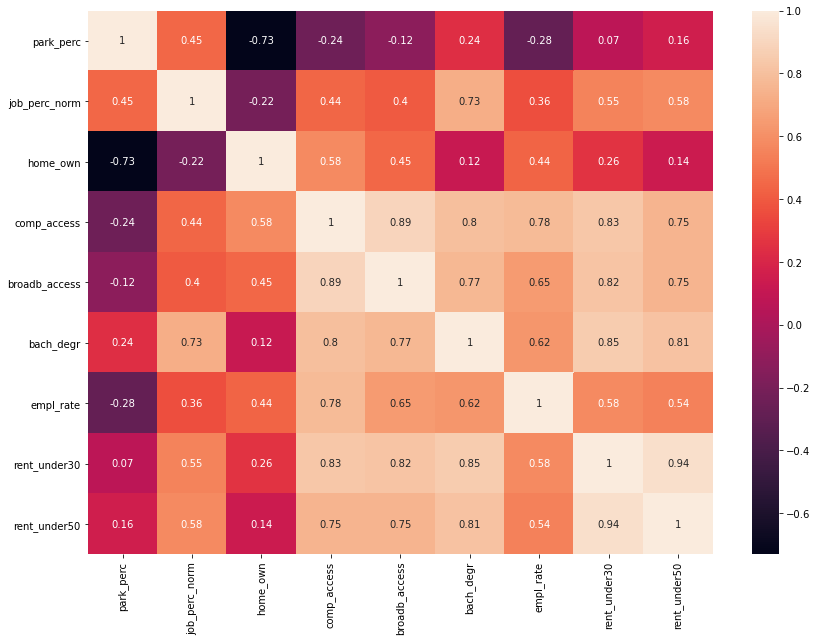

In [16]:
plt.subplots(figsize=(14,10))
sns.heatmap(X.corr(), annot = True)

Based on the correlation values, we'll remove rent cost 50% or less of HH income and broadband access for the analysis

### Dataset 7
7 features - park access, job access, home ownership, computer access, bachelor's degree, employment rate, rent under 30% of income

In [17]:
cols = ['PUMA',
 'park_perc',
 'job_perc_norm',
 'home_own',
 'comp_access',
 'bach_degr',
 'empl_rate',
 'rent_under30']

df_inputsT = df_inputs.loc[:, cols]
X7 = df_inputsT.iloc[:, 1:]
df_inputsT.head()

,PUMA,park_perc,job_perc_norm,home_own,comp_access,bach_degr,empl_rate,rent_under30
0,3603701,91.5,4.7,31.1,75.5,40.6,93.0,46.1
1,3603702,63.4,2.2,38.1,68.2,24.4,90.6,39.3
2,3603703,49.9,1.6,47.1,73.9,26.3,92.4,50.3
3,3603704,84.5,4.6,29.7,71.6,24.5,91.5,41.8
4,3603705,99.2,6.1,6.5,54.6,12.8,87.4,36.1


<AxesSubplot:>

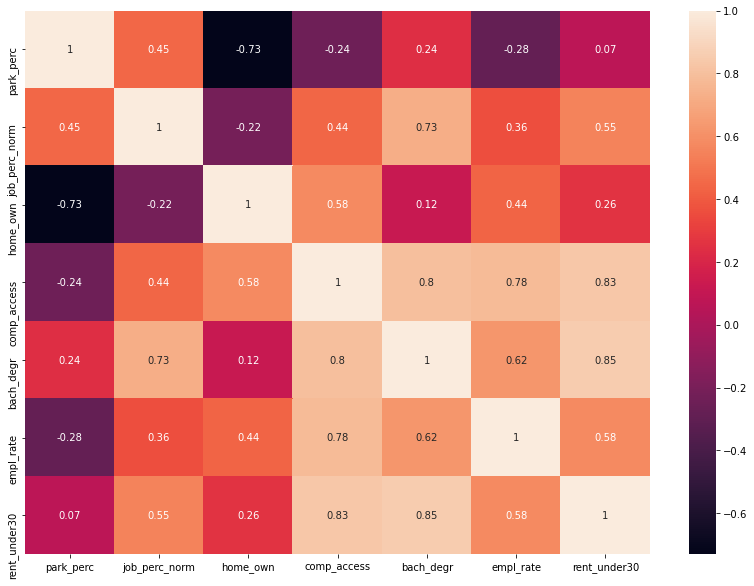

In [18]:
plt.subplots(figsize=(14,10))
sns.heatmap(X7.corr(), annot = True)

### Dataset 6
6 features - no home ownership variable

In [19]:
cols_ = ['PUMA',
 'park_perc',
 'job_perc_norm',
 'comp_access',
 'bach_degr',
 'empl_rate',
 'rent_under30']

df_inputsN = df_inputs.loc[:, cols_]
X6 = df_inputsN.iloc[:, 1:]
df_inputsN.head()

,PUMA,park_perc,job_perc_norm,comp_access,bach_degr,empl_rate,rent_under30
0,3603701,91.5,4.7,75.5,40.6,93.0,46.1
1,3603702,63.4,2.2,68.2,24.4,90.6,39.3
2,3603703,49.9,1.6,73.9,26.3,92.4,50.3
3,3603704,84.5,4.6,71.6,24.5,91.5,41.8
4,3603705,99.2,6.1,54.6,12.8,87.4,36.1


<AxesSubplot:>

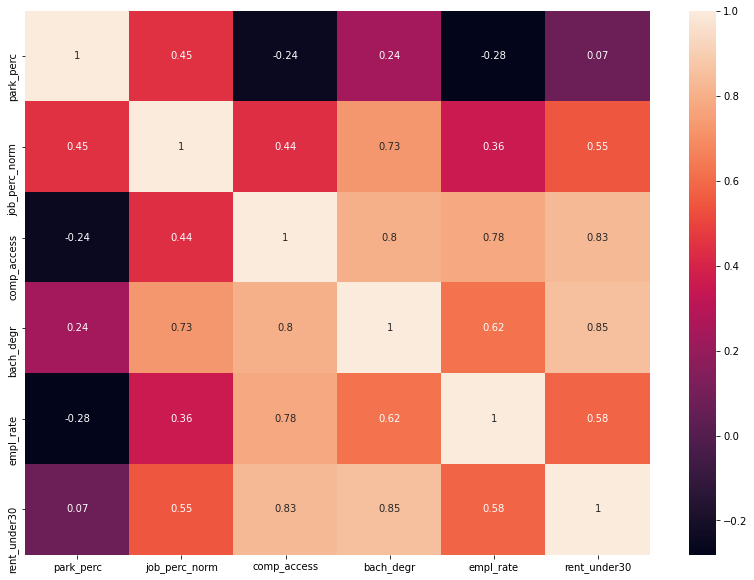

In [20]:
plt.subplots(figsize=(14,10))
sns.heatmap(X6.corr(), annot = True)

### Standardization:

No variable standardization for this analysis - all are on 0-100 scale

Sample code:

In [21]:
# scaler = StandardScaler()
# scalerNum = scaler.fit(X)
# Xstd = scalerNum.transform(X)

### Silhouette and Elbow Methods:

#### Dataset 7

In [24]:
for i in range(2,10):
    km = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    cluster_labels = km.fit_predict(X7)
    silhouette_avg = silhouette_score(X7, cluster_labels, metric='euclidean', sample_size = 10000, random_state=None)
    print('For n_clusters = {} the average silhouette_score is: {}'.format(i, silhouette_avg))

For n_clusters = 2 the average silhouette_score is: 0.5051166088927915
For n_clusters = 3 the average silhouette_score is: 0.3697741824973542
For n_clusters = 4 the average silhouette_score is: 0.33476262320459566
For n_clusters = 5 the average silhouette_score is: 0.3057831049922022
For n_clusters = 6 the average silhouette_score is: 0.3437907275661219
For n_clusters = 7 the average silhouette_score is: 0.3681826641361789
For n_clusters = 8 the average silhouette_score is: 0.35611163774788696
For n_clusters = 9 the average silhouette_score is: 0.34500854201308917


In [22]:
distorsions = []
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(X7)
    distorsions.append(kmeans.inertia_)

Text(0.5, 1.0, 'Elbow curve')

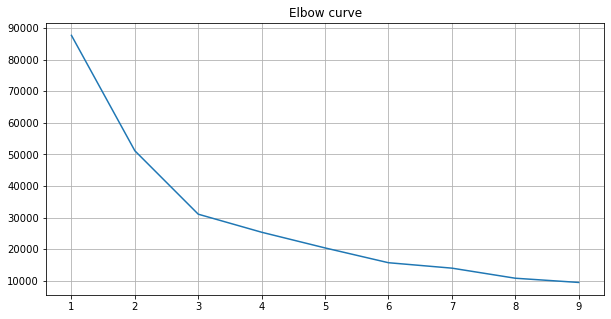

In [23]:
fig = plt.figure(figsize=(10, 5))
plt.plot(range(1, 10), distorsions)
plt.grid(True)
plt.title('Elbow curve')

#### Dataset 6

In [27]:
for i in range(2,10):
    km = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    cluster_labels = km.fit_predict(X6)
    silhouette_avg = silhouette_score(X6, cluster_labels, metric='euclidean', sample_size = 10000, random_state=None)
    print('For n_clusters = {} the average silhouette_score is: {}'.format(i, silhouette_avg))

For n_clusters = 2 the average silhouette_score is: 0.5890219139707068
For n_clusters = 3 the average silhouette_score is: 0.3386672510807089
For n_clusters = 4 the average silhouette_score is: 0.3769593472065096
For n_clusters = 5 the average silhouette_score is: 0.3864405358098936
For n_clusters = 6 the average silhouette_score is: 0.34023325491695317
For n_clusters = 7 the average silhouette_score is: 0.3236431402451012
For n_clusters = 8 the average silhouette_score is: 0.3793329304152591
For n_clusters = 9 the average silhouette_score is: 0.38320443696323453


In [25]:
distorsions = []
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(X6)
    distorsions.append(kmeans.inertia_)

Text(0.5, 1.0, 'Elbow curve')

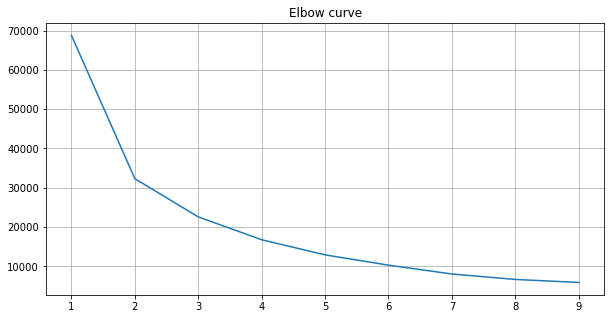

In [26]:
fig = plt.figure(figsize=(10, 5))
plt.plot(range(1, 10), distorsions)
plt.grid(True)
plt.title('Elbow curve')

## Clustering

K-means approach

Number of clusters, based on Silhoutte and Elbow coefficients:
    
    * Dataset 7 (home ownership included): k=3 (based on elbow method) and k=7 (based on silhouette score)
    * Dataset 6 (home ownership NOT included): k=2 (based on elbow method) and k=5 (based on silhouette score)

#### Dataset 7
where k=7 clusters

In [27]:
kmeans = KMeans(n_clusters = 7, init = 'k-means++', random_state = 42)
kmeans.fit(X7)
df_inputsT7 = df_inputsT.copy()
df_inputsT7['labels'] = kmeans.labels_
cluster_sumT7 = df_inputsT7.groupby(['labels']).agg({'park_perc':'mean','job_perc_norm':'mean','home_own':'mean',
                                                 'comp_access':'mean','bach_degr':'mean',
                                                 'empl_rate':'mean','rent_under30':'mean',
                                                 'PUMA':'count'})
cluster_sumT7.head(7)

,park_perc,job_perc_norm,home_own,comp_access,bach_degr,empl_rate,rent_under30,PUMA
labels,,,,,,,,
0,91.491667,11.466667,20.216667,73.325000,38.983333,93.283333,47.100000,12
1,60.728571,1.400000,68.014286,81.414286,33.014286,94.485714,48.857143,7
2,95.266667,93.433333,29.333333,90.900000,80.200000,96.100000,60.233333,3
3,95.525000,34.900000,35.250000,88.650000,74.350000,95.600000,60.725000,4
4,70.280000,5.140000,37.260000,75.335000,31.005000,93.700000,44.055000,20
5,96.700000,6.357143,9.842857,59.385714,14.500000,88.342857,36.900000,7
6,100.000000,53.100000,9.200000,68.850000,36.900000,93.450000,47.700000,2


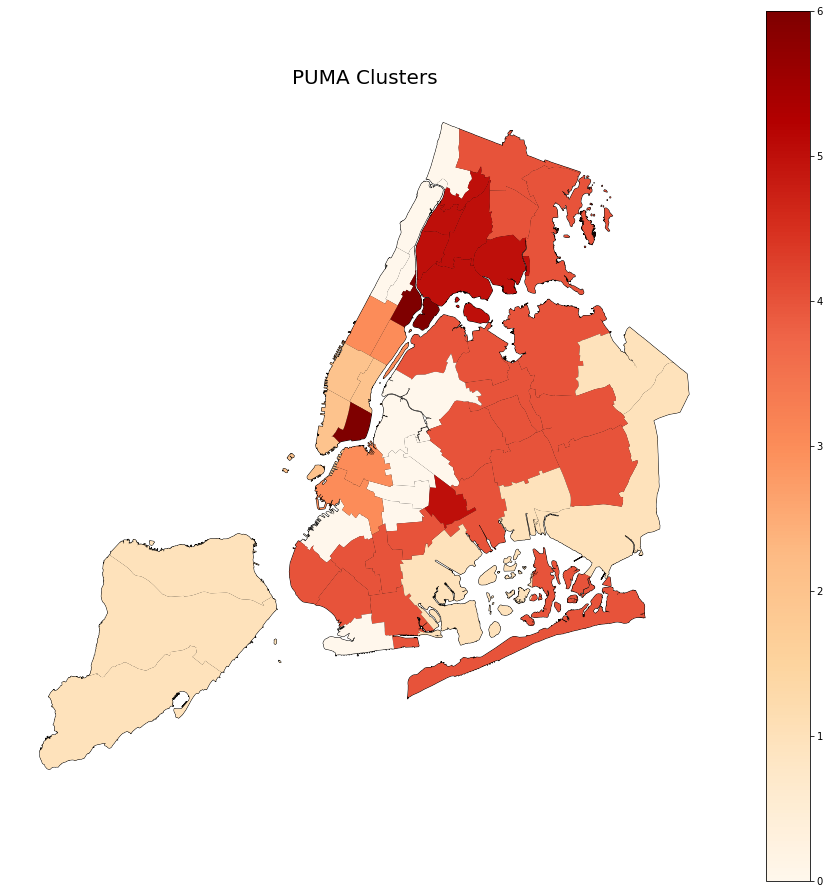

In [28]:
df_inputsT7['puma'] = df_inputsT7['PUMA'].str[3:]
cluster_shapefile = pd.merge(puma_shape, df_inputsT7, how='left', on='puma')
base = cluster_shapefile.plot(color='white', edgecolor='black', figsize=(16,16))
ax = cluster_shapefile.plot(column='labels',cmap='OrRd',ax=base)
ax.set_aspect='equal'
ax.axis('off')
sm = plt.cm.ScalarMappable(cmap='OrRd')
sm.set_array([0,1,2,3,4,5,6])
plt.colorbar(sm)
plt.title('PUMA Clusters',size=20)
plt.show()

#### Dataset 7
where k=3

In [29]:
kmeans = KMeans(n_clusters = 3, init = 'k-means++', random_state = 42)
kmeans.fit(X7)
df_inputsT3 = df_inputsT.copy()
df_inputsT3['labels'] = kmeans.labels_
cluster_sumT3 = df_inputsT3.groupby(['labels']).agg({'park_perc':'mean','job_perc_norm':'mean','home_own':'mean',
                                                 'comp_access':'mean','bach_degr':'mean',
                                                 'empl_rate':'mean','rent_under30':'mean',
                                                 'PUMA':'count'})
cluster_sumT3.head()

,park_perc,job_perc_norm,home_own,comp_access,bach_degr,empl_rate,rent_under30,PUMA
labels,,,,,,,,
0,65.682609,4.139130,48.091304,77.713043,33.091304,94.078261,45.869565,23
1,95.987500,60.937500,30.050000,87.550000,72.487500,95.650000,58.662500,8
2,91.450000,9.920833,18.070833,68.725000,28.804167,91.741667,43.387500,24


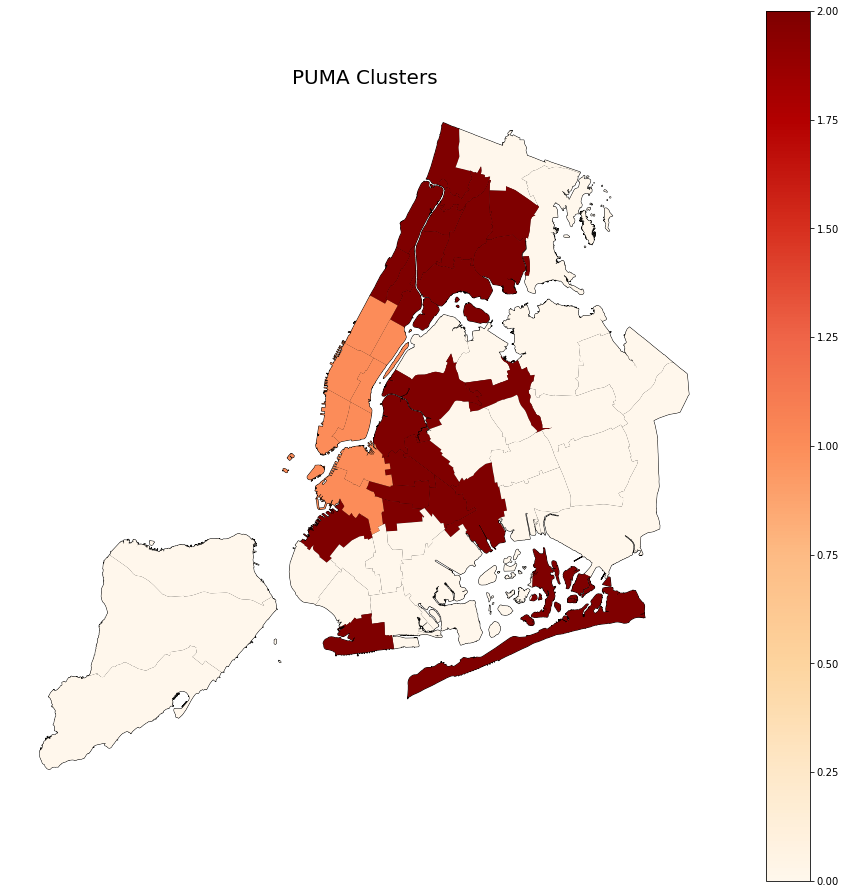

In [30]:
df_inputsT3['puma'] = df_inputsT3['PUMA'].str[3:]
cluster_shapefile = pd.merge(puma_shape, df_inputsT3, how='left', on='puma')
base = cluster_shapefile.plot(color='white', edgecolor='black', figsize=(16,16))
ax = cluster_shapefile.plot(column='labels',cmap='OrRd',ax=base)
ax.set_aspect='equal'
ax.axis('off')
sm = plt.cm.ScalarMappable(cmap='OrRd')
sm.set_array([0,1,2])
plt.colorbar(sm)
plt.title('PUMA Clusters',size=20)
plt.show()

#### Dataset 6
where k=5 clusters

In [31]:
kmeans = KMeans(n_clusters = 5, init = 'k-means++', random_state = 42)
kmeans.fit(X6)
df_inputsN5 = df_inputsN.copy()
df_inputsN5['labels'] = kmeans.labels_
cluster_sumN5 = df_inputsN5.groupby(['labels']).agg({'park_perc':'mean','job_perc_norm':'mean',
                                                 'comp_access':'mean','bach_degr':'mean',
                                                 'empl_rate':'mean','rent_under30':'mean',
                                                 'PUMA':'count'})
cluster_sumN5.head()

,park_perc,job_perc_norm,comp_access,bach_degr,empl_rate,rent_under30,PUMA
labels,,,,,,,
0,89.394118,11.482353,73.641176,38.552941,93.105882,47.405882,17
1,65.604348,4.069565,76.921739,30.239130,94.104348,44.873913,23
2,96.450000,86.975000,86.450000,70.625000,95.700000,56.600000,4
3,95.525000,34.900000,88.650000,74.350000,95.600000,60.725000,4
4,96.700000,6.357143,59.385714,14.500000,88.342857,36.900000,7


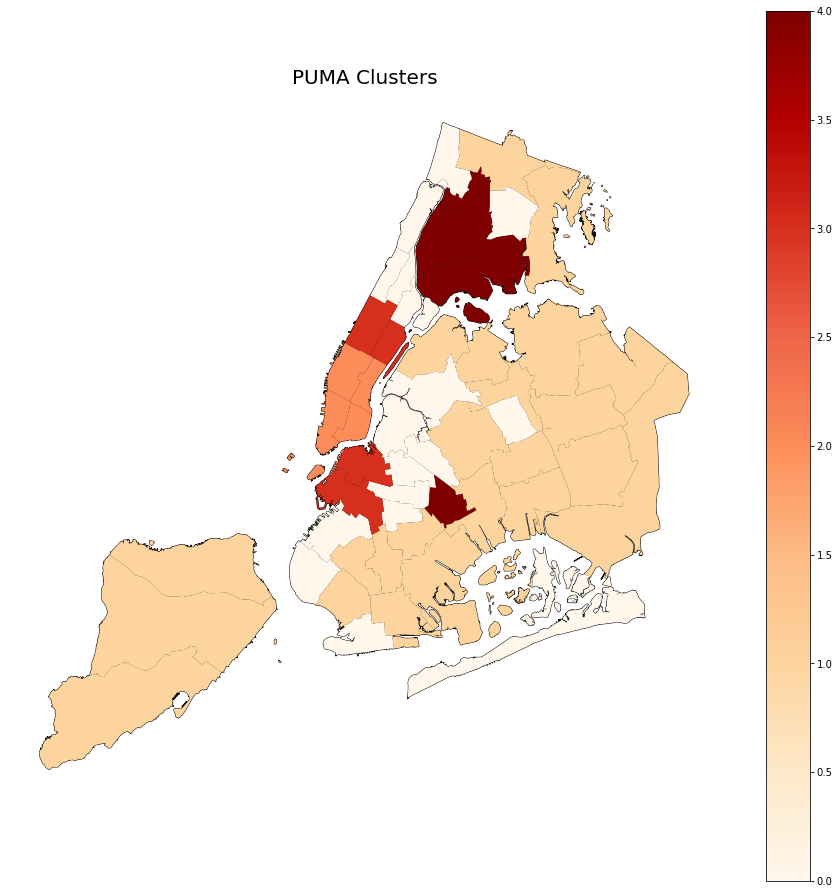

In [32]:
df_inputsN5['puma'] = df_inputsN5['PUMA'].str[3:]
cluster_shapefile = pd.merge(puma_shape, df_inputsN5, how='left', on='puma')
base = cluster_shapefile.plot(color='white', edgecolor='black', figsize=(16,16))
ax = cluster_shapefile.plot(column='labels',cmap='OrRd',ax=base)
ax.set_aspect='equal'
ax.axis('off')
sm = plt.cm.ScalarMappable(cmap='OrRd')
sm.set_array([0,1,2,3,4])
plt.colorbar(sm)
plt.title('PUMA Clusters',size=20)
plt.show()

#### Dataset 6
where k=2

In [33]:
kmeans = KMeans(n_clusters = 2, init = 'k-means++', random_state = 42)
kmeans.fit(X6)
df_inputsN2 = df_inputsN.copy()
df_inputsN2['labels'] = kmeans.labels_
cluster_sumN2 = df_inputsN2.groupby(['labels']).agg({'park_perc':'mean','job_perc_norm':'mean',
                                                 'comp_access':'mean','bach_degr':'mean',
                                                 'empl_rate':'mean','rent_under30':'mean',
                                                 'PUMA':'count'})
cluster_sumN2.head()

,park_perc,job_perc_norm,comp_access,bach_degr,empl_rate,rent_under30,PUMA
labels,,,,,,,
0,95.987500,60.937500,87.550000,72.487500,95.650000,58.662500,8
1,78.840426,7.091489,73.123404,30.902128,92.885106,44.602128,47


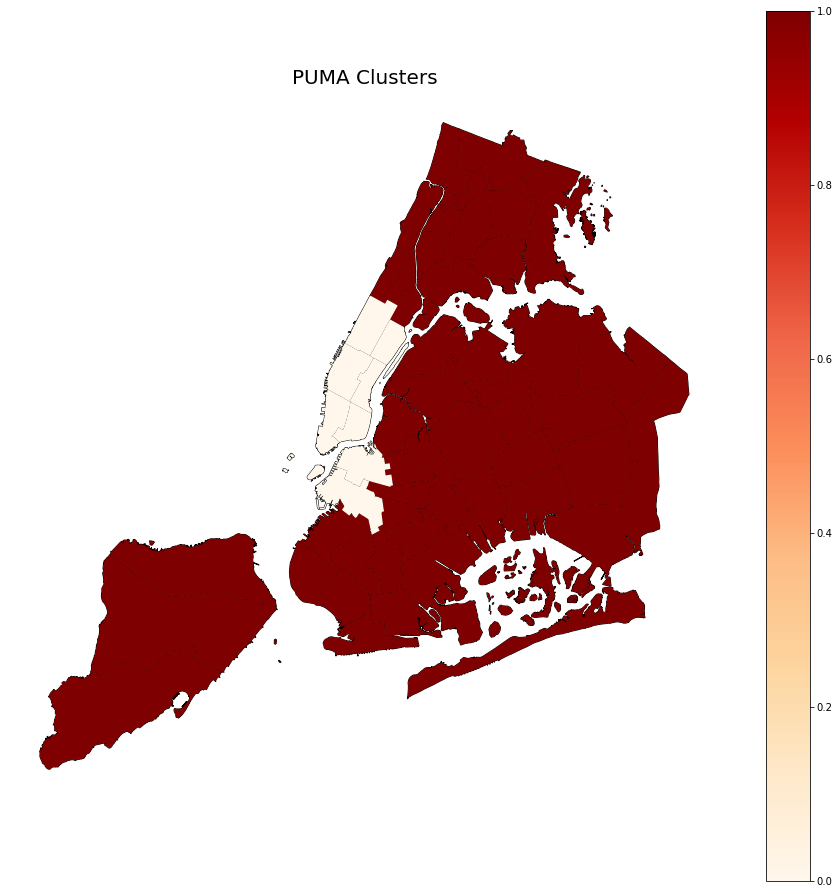

In [34]:
df_inputsN2['puma'] = df_inputsN['PUMA'].str[3:]
cluster_shapefile = pd.merge(puma_shape, df_inputsN2, how='left', on='puma')
base = cluster_shapefile.plot(color='white', edgecolor='black', figsize=(16,16))
ax = cluster_shapefile.plot(column='labels',cmap='OrRd',ax=base)
ax.set_aspect='equal'
ax.axis('off')
sm = plt.cm.ScalarMappable(cmap='OrRd')
sm.set_array([0,1])
plt.colorbar(sm)
plt.title('PUMA Clusters',size=20)
plt.show()